In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import IPython.display as display
import PIL.Image
import pathlib
import os

In [9]:
# Base model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [71]:
# Maximize the activations of these layers
names = ['mixed4', 'mixed7']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [72]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [73]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [74]:
deepdream = DeepDream(dream_model)

<font size='5'>
Load data
</font>

In [75]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

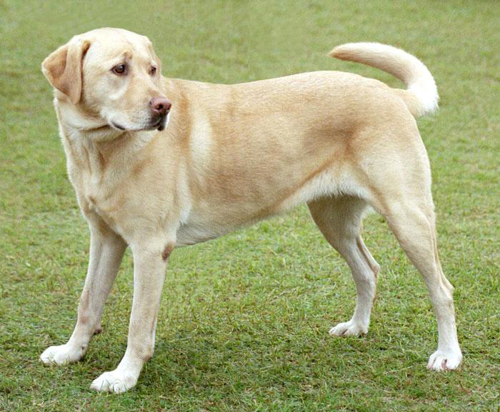

In [76]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [77]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

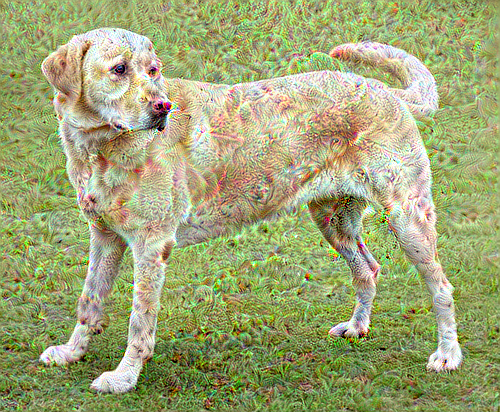

In [90]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.02)

<font size="5">
My implementation
<font>

In [79]:
# Paths to data
data_url = 'example_images'

data_dir = pathlib.Path(data_url)

# Lets see our number of samples
train_image_count = len(list(data_dir.glob('*.*')))
print(train_image_count)

10


In [80]:
# Check for corrupted files
def get_corrupted_files(data_dir, verbose=0, ret_split=0):
  """
  Checks if the images in the directory are corrupted or unusable.

  data_dir: directory of the data as pathlib.Path object
  verbose: print out corrupted file paths and number of total corrupt images
  ret_split: return lists of verified and corrupted images
  """

  count_opened = 0
  count_error = 0
  good_file_urls = []
  bad_file_urls = []

  # Iterate through files in directory
  for filename in os.listdir(data_dir):
    # File extension control
    if (filename.endswith('.jpg') or filename.endswith('.png') or 
        filename.endswith('.bmp') or filename.endswith('.JPG') or 
        filename.endswith('.jpeg')):
      
      curr_img_path = data_dir.name +"/"+filename
      # try to open the image
      try:
        img = PIL.Image.open(curr_img_path) # open the image file
        img.verify() # verify that it is an image
        good_file_urls.append(curr_img_path) #add to 'good' files
        count_opened += 1

      # exception for corrupted file
      except (IOError, SyntaxError) as e:
        bad_file_urls.append(curr_img_path)
        count_error += 1
        if verbose > 1:
          print('Bad file:', filename) # print out the names of corrupt files
        

  if verbose > 0:
    print(f"Checked: {count_opened+count_error}, verified: {count_opened}, corrupted: {count_error}")
  if ret_split > 0:
    return good_file_urls, bad_file_urls

In [81]:
good_urls, bas_urls = get_corrupted_files(data_dir,verbose=1, ret_split=1)

Checked: 10, verified: 10, corrupted: 0


In [82]:
def convert_img_to_np(file_url, max_dim=None):
    try:
      img = PIL.Image.open(file_url)
      if max_dim:
        img.thumbnail((max_dim, max_dim))
      img_np = np.array(img)
      return img_np

    except (IOError, SyntaxError) as e:
      print("bad file: ", file_url)

In [86]:
example_img = convert_img_to_np(good_urls[2], max_dim=1000)
example_img.shape

(750, 1000, 3)

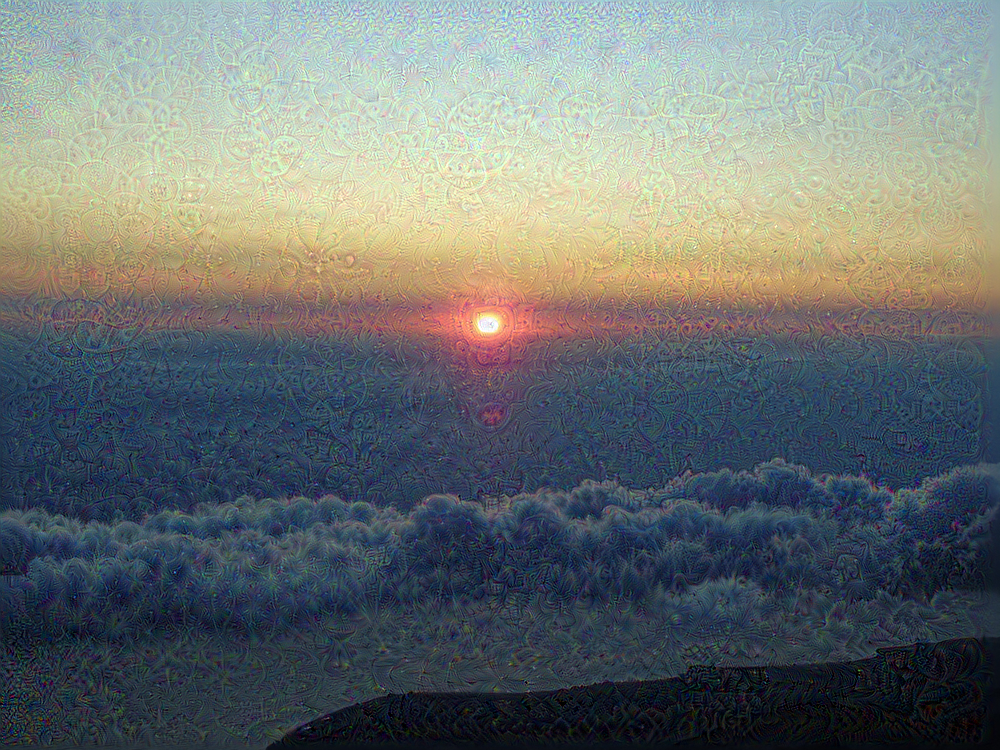

In [88]:
dream_img = run_deep_dream_simple(img=example_img, 
                                  steps=100, step_size=0.01)